<div style="background: linear-gradient(90deg, 
              rgba(135, 206, 250, 1) 0%, 
              rgba(123, 104, 238, 1) 100%);
            color: white;
            text-align: center;
            padding: 20px;
            font-family: 'Arial', sans-serif;
            font-size: 36px;
            font-weight: bold;
            border-radius: 10px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <span style="color: #ffffff;">🖼️ Image Captioning: CNN Encoder + LSTM Decoder ✍</span>
</div>


# Image Captioning with CNN + LSTM ✨

This notebook builds a model to generate captions for images using:
- **CNN (ResNet50)** as encoder
- **LSTM** as decoder
- **Flickr8k** dataset
- **TensorFlow/Keras**


In [1]:
import os, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version:", tf.__version__)
print("GPU available:", "Yes" if tf.config.list_physical_devices('GPU') else "No")


TensorFlow version: 2.19.0
GPU available: No


# 📚 Dataset: Flickr8k

The **Flickr8k** dataset contains **8,000 images**, each paired with **5 different captions**, making it ideal for training and demonstrating image captioning models in a lightweight environment.


# 📁 Load & Inspect Dataset

In [2]:
# Paths
IMAGE_DIR = "Images"
CAPTIONS_FILE = "captions.txt"

# Load captions (CSV format)
captions = {}
with open(CAPTIONS_FILE, 'r') as f:
    next(f)  # skip header line
    for line in f:
        img, caption = line.strip().split(',', 1)  # split only on first comma
        captions.setdefault(img, []).append(caption)

# Show sample
print("Example image:", list(captions.keys())[0])
print("Captions:", captions[list(captions.keys())[0]])
print("Total images:", len(captions))


Example image: 1000268201_693b08cb0e.jpg
Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Total images: 8091


# 🔍 Caption Preprocessing

In [3]:
import re
def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-z ]+", '', text)
    tokens = text.split()
    return ' '.join(['<start>'] + tokens + ['<end>'])

captions_cleaned = {img: [clean_caption(c) for c in caps] for img, caps in captions.items()}


# 🏗️ Build Vocabulary

In [4]:
from collections import Counter
counter = Counter()
for caps in captions_cleaned.values():
    for cap in caps:
        counter.update(cap.split())

vocab = [w for w, cnt in counter.items() if cnt >= 5]
word2idx = {w:i+1 for i, w in enumerate(vocab)}
word2idx['<pad>'] = 0
idx2word = {i:w for w, i in word2idx.items()}
vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)


Vocabulary size: 2987


# 🖼️ Image Feature Extraction

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

encoder = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, 0)
    arr = preprocess_input(arr)
    return encoder.predict(arr).reshape(-1)

# Safe extraction with try-except and skip missing files
features = {}
files = list(captions_cleaned.keys())[:1000]
for fn in files:
    path = os.path.join(IMAGE_DIR, fn)
    if os.path.exists(path):
        try:
            features[fn] = extract_features(path)
        except Exception as e:
            print(f"[WARN] Failed on {fn}: {e}")
    else:
        print(f"[MISSING] {fn} not found.")

print("Extracted features for", len(features), "images")


[MISSING] 1000268201_693b08cb0e.jpg not found.
[MISSING] 1001773457_577c3a7d70.jpg not found.
[MISSING] 1002674143_1b742ab4b8.jpg not found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 

# 📚 Vocabulary Size

In [6]:
from collections import Counter
counter = Counter()
for caps in captions_cleaned.values():
    for cap in caps:
        counter.update(cap.split())

vocab = [w for w, cnt in counter.items() if cnt >= 5]
vocab = ['<pad>', '<unk>'] + vocab  # add pad and unknown tokens at start

word2idx = {w:i for i, w in enumerate(vocab)}
idx2word = {i:w for w, i in word2idx.items()}
vocab_size = len(word2idx)

print("Vocabulary size:", vocab_size)


Vocabulary size: 2988


# 🧠 Prepare Sequences for Training

In [9]:
captions_cleaned

{'1000268201_693b08cb0e.jpg': ['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
  '<start> a girl going into a wooden building <end>',
  '<start> a little girl climbing into a wooden playhouse <end>',
  '<start> a little girl climbing the stairs to her playhouse <end>',
  '<start> a little girl in a pink dress going into a wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> a black dog and a spotted dog are fighting <end>',
  '<start> a black dog and a tricolored dog playing with each other on the road <end>',
  '<start> a black dog and a white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <end>',
  '<start> a little girl is sitting in front

In [15]:
max_len = max(len(c.split()) for caps in captions_cleaned.values() for c in caps)

def create_sequences(img_id, caps_list):
    img_feat = features[img_id]
    seq_input, img_feats, next_word = [], [], []
    for cap in caps_list:
        words = cap.split()
        for i in range(1, len(words)):
            # Use <unk> index if word not found
            in_seq = [word2idx.get(w, word2idx['<unk>']) for w in words[:i]]
            out_word = word2idx.get(words[i], word2idx['<unk>'])
            seq_input.append(keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_len, padding='post')[0])
            next_word.append(out_word)
            img_feats.append(img_feat)
    return np.array(img_feats), np.array(seq_input), np.array(next_word)

# Build arrays for first 800 images
X1, X2, y = [], [], []
filtered_files = [f for f in files[:800] if f in captions_cleaned]

for img_id in filtered_files:
    xf, seqi, nxt = create_sequences(img_id, captions_cleaned[img_id])
    X1.extend(xf)
    X2.extend(seqi)
    y.extend(nxt)

X1, X2, y = np.array(X1), np.array(X2), np.array(y)
y = keras.utils.to_categorical(y, vocab_size)
print("Training samples:", X1.shape, X2.shape, y.shape)


Training samples: (47750, 2048) (47750, 37) (47750, 2988)


# 🧩 Define Model (Encoder–Decoder)

In [16]:
# Image feature input
inputs1 = layers.Input(shape=(2048,))
fe1 = layers.Dense(256, activation='relu')(inputs1)
# Sequence input
inputs2 = layers.Input(shape=(max_len,))
se1 = layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = layers.LSTM(256)(se1)
# Merge
decoder1 = layers.add([fe1, se2])
decoder2 = layers.Dense(256, activation='relu')(decoder1)
outputs = layers.Dense(vocab_size, activation='softmax')(decoder2)
model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 37)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 37, 256)           │         764,928 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 37)                │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         524,544 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ embedding[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense[0][0], lstm[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2988)              │         767,916 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,648,492 (10.10 MB)

 Trainable params: 2,648,492 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

# 🏋️ Train Model

In [17]:
history = model.fit([X1, X2], y, epochs=20, batch_size=64, validation_split=0.1)


Epoch 1/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 168s 245ms/step - loss: 4.9805 - val_loss: 3.9795
Epoch 2/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 146s 217ms/step - loss: 3.4101 - val_loss: 3.8091
Epoch 3/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 142s 212ms/step - loss: 2.8707 - val_loss: 3.8327
Epoch 4/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 144s 215ms/step - loss: 2.4586 - val_loss: 3.9342
Epoch 5/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 146s 217ms/step - loss: 2.1168 - val_loss: 4.0814
Epoch 6/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 149s 222ms/step - loss: 1.8681 - val_loss: 4.1912
Epoch 7/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 149s 222ms/step - loss: 1.6520 - val_loss: 4.3992
Epoch 8/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 149s 221ms/step - loss: 1.4616 - val_loss: 4.6928
Epoch 9/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 148s 220ms/step - loss: 1.3103 - val_loss: 4.8724
Epoch 10/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 149s 222ms/step - loss: 1.1716 - val_loss: 5.1885
Epoch 11/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 148s 221ms/step - loss: 1.0515 - val_loss: 5.3710
Epoch 12

# 🖼️ Display Multiple Images with Predicted Captions

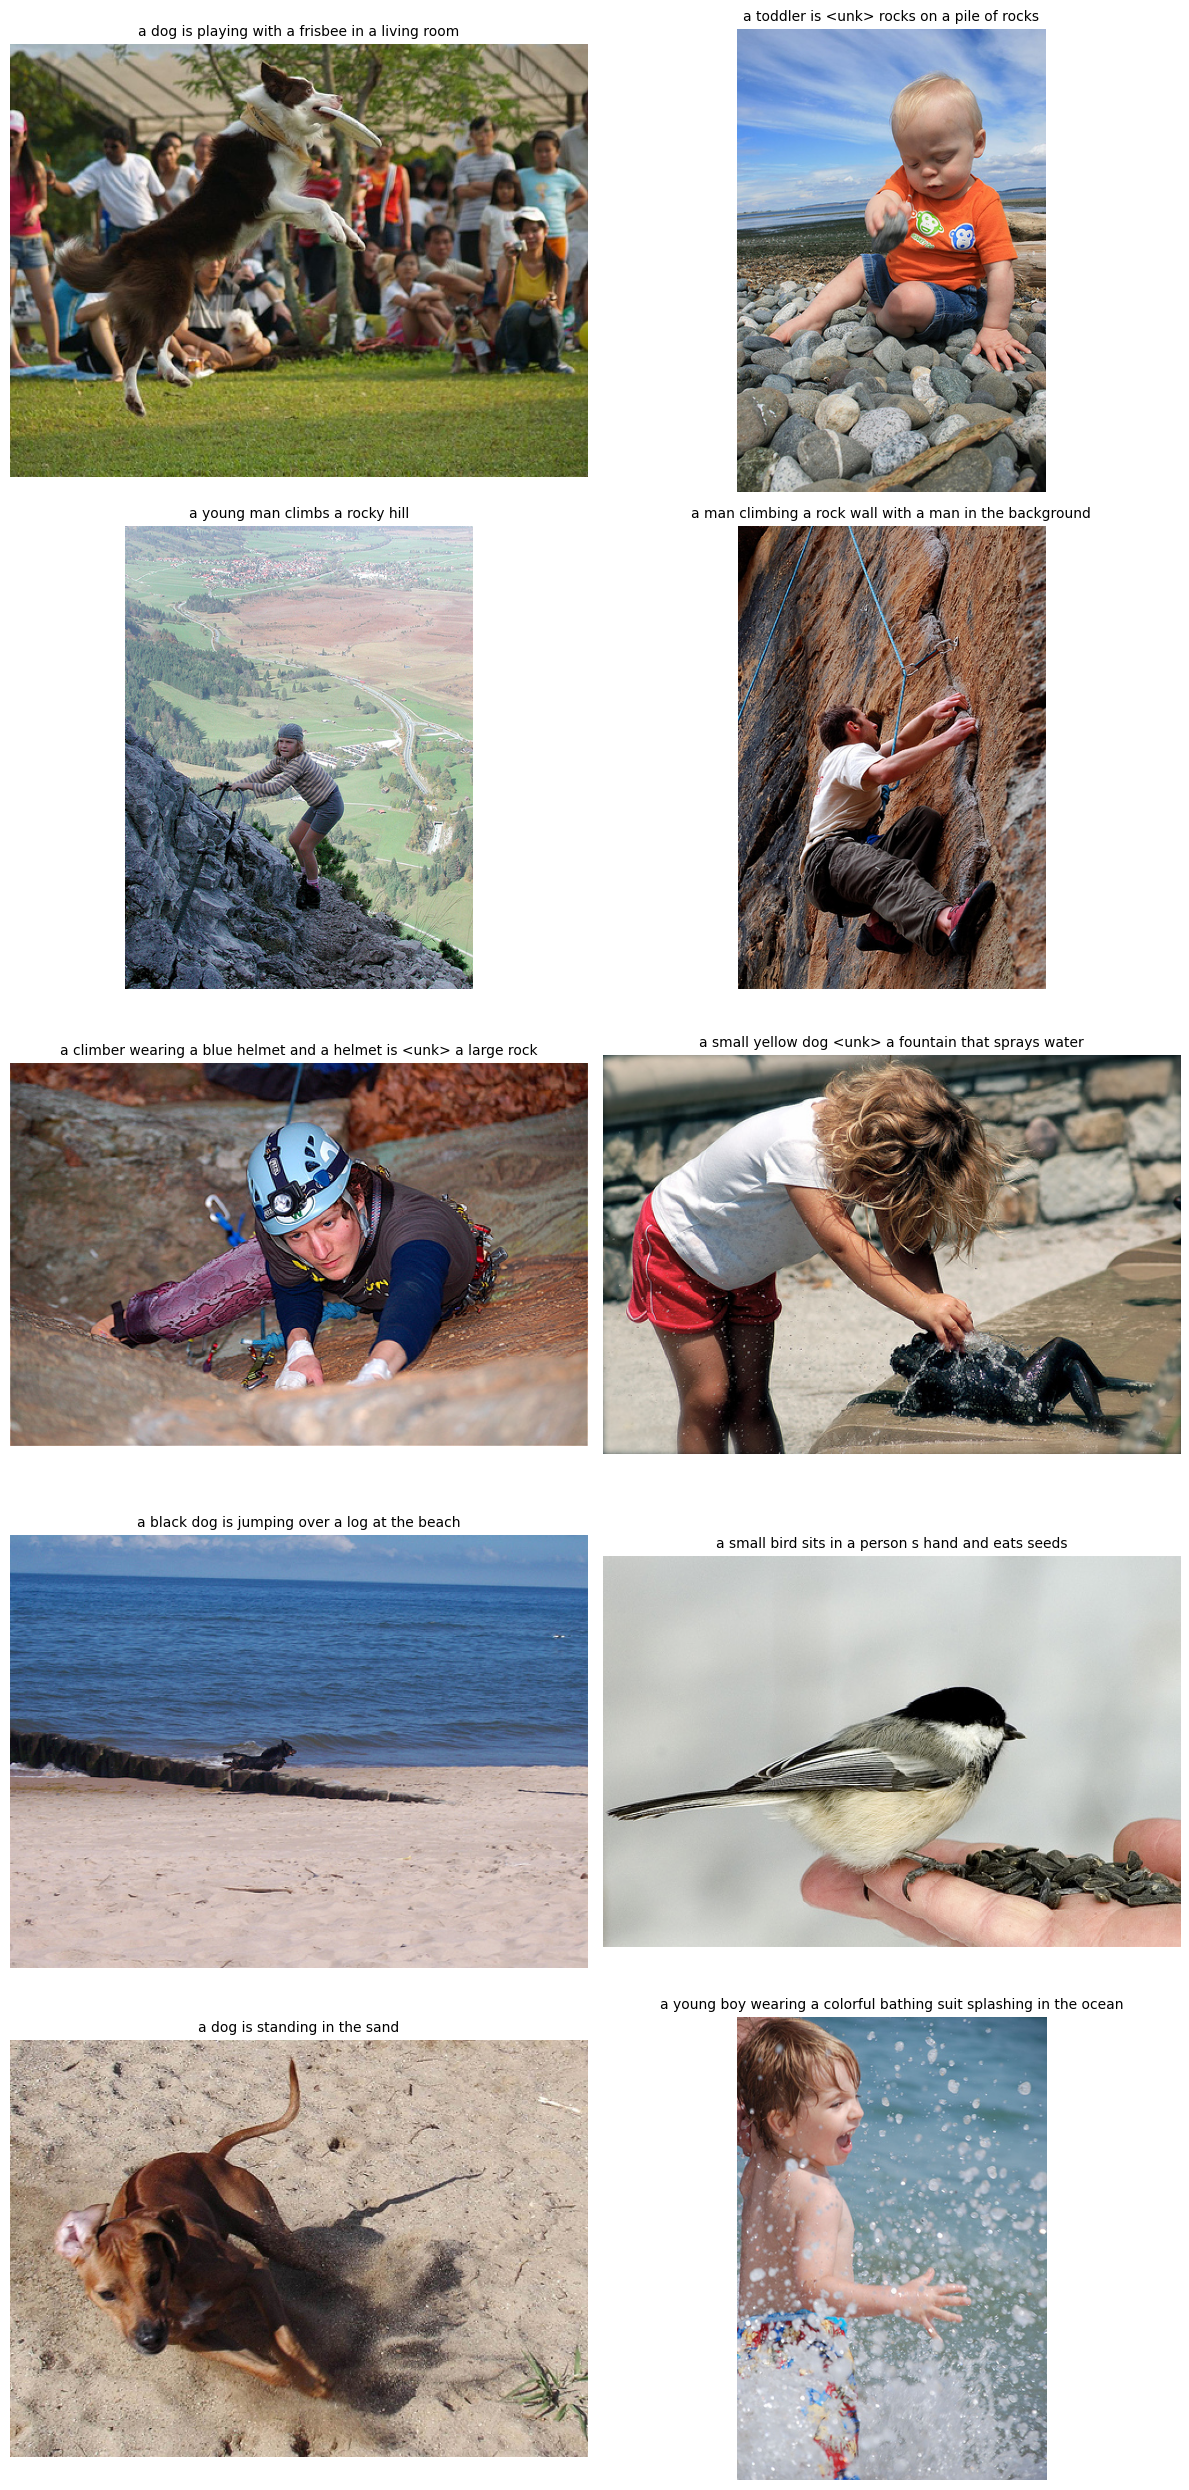

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

# Function to generate a caption for one image
def generate_caption(img_feat):
    in_text = ['<start>']
    for _ in range(max_len):
        seq = [word2idx.get(w, 0) for w in in_text]
        seq = keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_len, padding='post')
        yhat = model.predict([img_feat.reshape(1, -1), seq], verbose=0)
        w = idx2word[np.argmax(yhat)]
        if w == '<end>':
            break
        in_text.append(w)
    return ' '.join(in_text[1:])

# Function to show images with captions (2 per row)
def show_images_with_captions(image_files, features, num_images=4):
    rows = (num_images + 1) // 2  # 2 images per row
    plt.figure(figsize=(12, 5 * rows))

    for i in range(num_images):
        file = image_files[i]
        caption = generate_caption(features[file])
        img = load_img(f"Images/{file}")

        plt.subplot(rows, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(caption, fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage: show 4 images, 2 per row
show_images_with_captions(files[100:110], features, num_images=10)
